In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.utils import is_undirected, to_undirected

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax



In [3]:
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3])
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])
print(G1)

Graph with 3 nodes and 3 edges


In [3]:
list(G1.edges)

[(1, 2), (1, 3), (2, 3)]

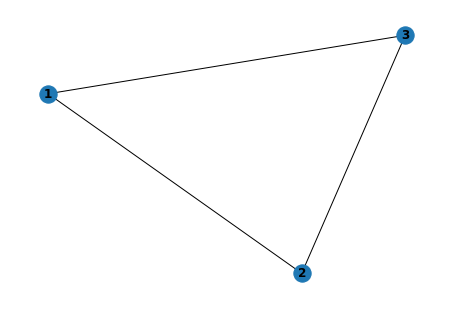

In [4]:
nx.draw(G1, with_labels=True, font_weight='bold')

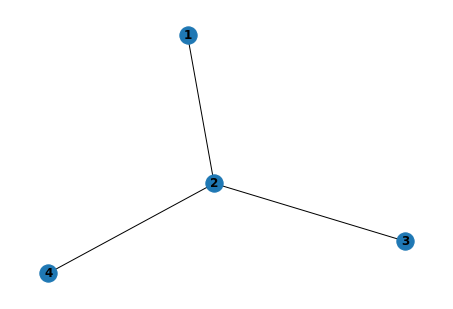

In [5]:
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4])
G2.add_edges_from([(1, 2), (2, 3), (2, 4)])
nx.draw(G2, with_labels=True, font_weight='bold')

In [7]:
g_int = nx.intersection(G1, G2)

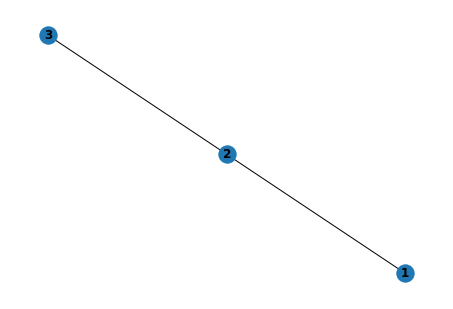

In [8]:
g_int.remove_nodes_from(list(nx.isolates(g_int)))
nx.draw(g_int, with_labels=True, font_weight='bold')


In [9]:
n_tp = g_int.number_of_edges()
n_tp

2

In [10]:
n_fp = len(G1.edges() - g_int.edges())
n_fp

1

In [11]:
n_fn = len(G2.edges() - g_int.edges())
n_fn

1

In [12]:
G2.edges() - g_int.edges()

{(2, 4)}

In [13]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f1_score = 2*(precision * recall)/(precision + recall)
f1_score

0.6666666666666666

In [14]:
nx.graph_edit_distance(G1, G2)

3.0

In [2]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis, n_shapes, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [140]:
n_basis, n_shapes = 2000, 200

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')

In [141]:
plugins

array([1325, 1480,  167,  629,  190,  869, 1511,  172, 1925,  933, 1573,
        199,  967,  636,  837,  663,  439,  569, 1693,  562,  617,  311,
       1769,   50,  843, 1557, 1763,  881, 1958, 1139,  982,  233,  335,
        993, 1700,   55, 1390,  177,  787,  259,  895, 1000, 1956,  428,
        640,  634, 1849,  449, 1090, 1112, 1542, 1160,  495,  632, 1455,
        743,  914, 1525,  464,  103, 1791,  891,  211,  330,  253,  828,
        475, 1389, 1986, 1011, 1660, 1458,  549,  734, 1947,  696, 1829,
       1133,  898, 1861, 1260,  267,  216,  499, 1685,  581,  298,  718,
       1822, 1145, 1015, 1272,    6,  751,   14,  754,  214,  155,  611,
       1469, 1522,  659,  434,  812,  161,  106, 1800, 1806, 1138, 1302,
        976, 1775,  351, 1923,   67,  258, 1017,  324,  257, 1512, 1996,
        396,   32,  307, 1353,  894, 1739, 1588, 1927,  759,  793,  958,
        830, 1968,  738, 1118, 1676, 1606,  505, 1941, 1634,  567,  594,
       1443,  558, 1329, 1201, 1085, 1914, 1312,   

In [142]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    #adj = np.expand_dims(adj, axis=0)
    #f = np.expand_dims(f, axis=0)
    #labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [167]:
n_basis, n_shapes = 6, 2

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')
d = from_networkx(G.to_undirected(), all)
d.edge_index

tensor([[ 0,  0,  0,  0,  0,  1,  2,  2,  3,  3,  4,  5,  6,  6,  6,  7,  7,  7,
          7,  8,  8,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 15],
        [ 1,  2,  3,  4,  5,  0,  0, 14,  0,  7,  0,  0,  7,  9, 10,  3,  6,  8,
         10,  7,  9,  6,  8,  6,  7, 12, 14, 15, 11, 13, 15, 12, 14,  2, 11, 13,
         11, 12]])

In [253]:
d.num_features

1

In [182]:
edge_mask = np.random.rand(d.edge_index.shape[1])
edge_mask

array([0.79521352, 0.4176716 , 0.19033216, 0.34551646, 0.70681497,
       0.21719544, 0.16267109, 0.72186861, 0.79775725, 0.91857462,
       0.22957565, 0.46894635, 0.69333696, 0.43067544, 0.89081547,
       0.57608833, 0.90840738, 0.15760443, 0.98307036, 0.5748036 ,
       0.19956709, 0.95964941, 0.60067702, 0.37854093, 0.13836074,
       0.3480738 , 0.78852359, 0.42653278, 0.86522091, 0.37247883,
       0.29108865, 0.89698142, 0.06448264, 0.11672851, 0.16269647,
       0.24360859, 0.20633366, 0.85676303])

In [183]:
a = d.edge_index.T
for i, (u, v) in enumerate(a.tolist()):
    if u > v:
        indices = [idx for idx in range(len(a)) if all(ele in a[idx] for ele in [u, v])]
        if len(indices) == 2:
            edge_mask[indices[0]] = edge_mask[indices[1]]
#a[i[:k]]

In [184]:
edge_mask

array([0.21719544, 0.16267109, 0.79775725, 0.22957565, 0.46894635,
       0.21719544, 0.16267109, 0.11672851, 0.79775725, 0.57608833,
       0.22957565, 0.46894635, 0.90840738, 0.95964941, 0.37854093,
       0.57608833, 0.90840738, 0.5748036 , 0.13836074, 0.5748036 ,
       0.60067702, 0.95964941, 0.60067702, 0.37854093, 0.13836074,
       0.86522091, 0.16269647, 0.20633366, 0.86522091, 0.89698142,
       0.85676303, 0.89698142, 0.24360859, 0.11672851, 0.16269647,
       0.24360859, 0.20633366, 0.85676303])

In [252]:
a = torch.Tensor([0.,0.,1.0,0.7, 1.7, -4])
def normalize(x):
    return (x - min(x)) / (max(x) - min(x))
a = normalize(a)
a

tensor([0.7018, 0.7018, 0.8772, 0.8246, 1.0000, 0.0000])

In [249]:
random.seed(10)
random.choices(edge_mask, k=3)

[0.9596494133788865, 0.9084073792675581, 0.9596494133788865]

In [237]:
def topk_edges(edge_mask, edge_index, num_top_edges = 6):
    num_top_edges = 6
    indices = (-edge_mask).argsort()
    top = np.array([], dtype='int')
    i = 0
    list_edges = np.sort(edge_index.T, axis=1)
    while len(top)<num_top_edges:
        subset = indices[num_top_edges*i:num_top_edges*(i+1)]
        topk_edges = list_edges[subset]
        u, idx = np.unique(topk_edges, return_index=True, axis=0)
        top = np.concatenate([top, subset[idx]], dtype=np.int32)
        i+=1
    return top[:num_top_edges]

In [230]:
topk_edges(edge_mask, d.edge_index, num_top_edges = 6)

array([12, 21, 29,  2, 28, 37], dtype=int32)

In [143]:
data = from_networkx(G, all)
data.edge_index

tensor([[   0,    0,    0,  ..., 2998, 2999, 2999],
        [   1,    2,    3,  ..., 2997, 2995, 2996]])

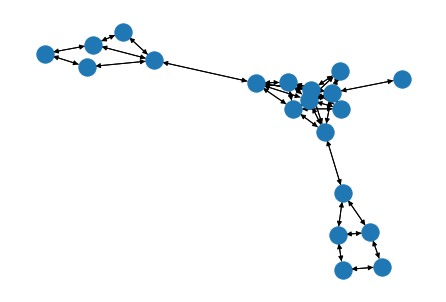

In [100]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g)

In [298]:
x = torch.LongTensor([[1],[1],[1]])
e = torch.LongTensor([[1,0,2], [0,2,1]])
d = Data(x=x, edge_index=e)
d.num_nodes = x.shape[0]
G = to_networkx(d)
G

In [144]:
data.num_node_features
data.num_classes = len(np.unique(labels))
data.y = torch.LongTensor(labels)

In [145]:
n = data.num_nodes
data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8)

In [146]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

data.train_mask[train_ids] = 1
data.val_mask[val_ids] = 1
data.test_mask[test_ids] = 1

In [147]:
len(data.y[data.val_mask])

/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_69301/2781205052.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  len(data.y[data.val_mask])


360

In [148]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [149]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, hidden_dim):
        super().__init__()
        self.num_node_features, self.num_classes, self.num_layers, self.hidden_dim = num_node_features, num_classes, num_layers, hidden_dim
        self.layers = torch.nn.ModuleList()
        current_dim = self.num_node_features
        for l in range(self.num_layers - 1):
            self.layers.append(GCNConv(current_dim, hidden_dim))
            current_dim = hidden_dim
        self.layers.append(GCNConv(current_dim, self.num_classes))

    def forward(self, x, edge_index, edge_weight=None):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.layers[-1](x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)


In [275]:
node_idx = torch.LongTensor([0])
subset = torch.LongTensor([13, 10, 4, 8, 7])
if node_idx not in subset:
    subset = torch.cat([node_idx, subset])
pos_node_idx = (subset==node_idx).nonzero().item()

tensor([ 0, 13, 10,  4,  8,  7])
tensor([ 0,  4,  7,  8, 10, 13]) tensor([0, 5, 4, 1, 3, 2])
1


tensor([0])

In [276]:
a = [[3,4], [12, 11], [9, 2]]
b = np.unique(a)
b

array([ 2,  3,  4,  9, 11, 12])

In [277]:
d = {v: k for k, v in enumerate(b)}
d

{2: 0, 3: 1, 4: 2, 9: 3, 11: 4, 12: 5}

In [287]:
# Function to be vectorized
def map_func(val, dictionary):
    return dictionary[val] if val in dictionary else val 

# Vectorize map_func
vfunc  = np.vectorize(map_func)

# Run
d = {v: k for k, v in enumerate(b)}
res = vfunc(a, d)


In [288]:
torch.LongTensor(res)

tensor([[1, 2],
        [5, 4],
        [3, 0]])

In [291]:
vfunc(9, d)

array(3)

In [272]:
#num_nodes = len(subset)
#nodes_idx = torch.zeros(num_nodes, dtype=torch.long, device=device)
nodes_idx = torch.arange(subset.size(0), device=device)
nodes_idx

tensor([0, 1, 2, 3, 4, 5])

In [150]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, data.num_classes, 2, 16).to(device)
data = data.to(device)
print(data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []
        

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    #scheduler.step(val_loss)

Data(edge_index=[2, 22750], x=[3000, 1], num_classes=4, y=[3000], train_mask=[3000], val_mask=[3000], test_mask=[3000])


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_69301/1776601654.py:24: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_69301/1776601654.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])


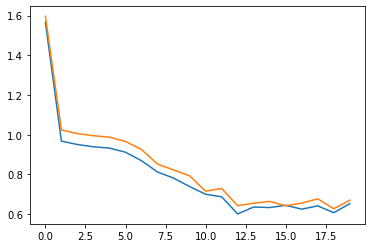

In [151]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [152]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_69301/1796556738.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()


In [153]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7912


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_69301/3035444030.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()


In [154]:
def list_to_dict(preds):
    preds_dict=pd.DataFrame(preds).to_dict('list')
    for key in preds_dict.keys():
        preds_dict[key] = np.array(preds_dict[key])
    return(preds_dict)


In [155]:
import random 
random.seed(1)
pred = model(data.x, data.edge_index).argmax(dim=1)
list_node_idx = np.where(pred == data.y)[0]
list_node_idx_house = list_node_idx[list_node_idx>n_basis]
test_nodes = [x.item() for x in random.choices(list_node_idx_house, k=10)]

In [156]:
from sklearn import metrics


def get_explanation(data, edge_mask, num_top_edges=6, is_hard_mask=False):
    if is_hard_mask:
        explanation = data.edge_index[:, np.where(edge_mask == 1)[0]]
    else:
        indices = (-edge_mask).argsort()[:num_top_edges]
        explanation = data.edge_index[:, indices]

    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))

    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)

    return (G_expl)

def get_ground_truth_ba_shapes(node, data):
    base = [0, 1, 2, 3, 4]
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)

    true_node_mask = np.zeros(data.edge_index.shape[1])
    true_node_mask[ground_truth] = 1
    true_edge_mask = node_attr_to_edge(data.edge_index, true_node_mask)

    return graph, role, true_edge_mask


def get_scores(G1, G2):
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged



In [158]:
def eval_accuracy(data, edge_masks, list_node_idx, num_top_edges, is_hard_mask=False):
    n_test = len(list_node_idx)
    scores = []
    
    for i in range(n_test):
    
        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]
        entry = get_accuracy(data, edge_mask, node_idx, num_top_edges, is_hard_mask)
        scores.append(entry)
        
    scores = list_to_dict(scores)
    accuracy_scores = {k:np.mean(v) for k,v in scores.items()}
    return(accuracy_scores)


def get_accuracy(data, edge_mask, node_idx, num_top_edges, is_hard_mask=False):
    G_true, role, true_edge_mask = get_ground_truth_ba_shapes(node_idx, data)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges, is_hard_mask=is_hard_mask)
    plt.figure()
    nx.draw(G_expl,  with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    recall, precision, f1_score, ged = get_scores(G_expl, G_true)
    fpr, tpr, thresholds = metrics.roc_curve(true_edge_mask, edge_mask, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    return {'recall':recall, 'precision':precision, 'f1_score':f1_score, 'ged':ged, 'auc':auc}

In [159]:
from scipy.special import softmax

def eval_related_pred(model, data, edge_masks, list_node_idx, hard_mask=False, **kwargs):

    zero_mask = torch.zeros(data.edge_index.shape[1])

    ori_preds = model(data.x, data.edge_index)
    zero_mask_preds = model(x=data.x, edge_index=data.edge_index, edge_weight=zero_mask)
    
    
    n_test = len(list_node_idx)
    related_preds = []
    
    for i in range(n_test):
    
        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]

        if hard_mask:
            #masked_edge_index = data.edge_index[:,edge_mask>kwargs['threshold']]
            #maskout_edge_index = data.edge_index[:,1-edge_mask>kwargs['threshold']]

            indices = (-edge_mask).argsort()[:kwargs['num_top_edges']]
            indices_inv = [i for i in range(len(edge_mask)) if i not in indices]
            masked_edge_index = data.edge_index[:, indices]
            maskout_edge_index = data.edge_index[:, indices_inv]

            masked_preds = model(data.x, masked_edge_index)
            maskout_preds = model(data.x, maskout_edge_index)
        else:
            masked_preds = model(x=data.x, edge_index=data.edge_index, edge_weight=edge_mask)
            maskout_preds = model(x=data.x, edge_index=data.edge_index, edge_weight=1-edge_mask)


        ori_probs = softmax(ori_preds[node_idx].detach().numpy())
        masked_probs = softmax(masked_preds[node_idx].detach().numpy())
        maskout_probs = softmax(maskout_preds[node_idx].detach().numpy())
        zero_mask_probs = softmax(zero_mask_preds[node_idx].detach().numpy())

        
        true_label = data.y[node_idx].detach().numpy()
        pred_label = np.argmax(ori_probs)
        assert true_label==pred_label, "The label predicted by the GCN does not match the true label."

        related_preds.append({'zero': zero_mask_probs,
                                      'masked': masked_probs,
                                      'maskout': maskout_probs,
                                      'origin': ori_probs,
                                        'true_label': true_label})
        
    related_preds = list_to_dict(related_preds)
    return related_preds




def fidelity_acc(related_preds):
    labels = related_preds['true_label']
    ori_labels = np.argmax(related_preds['origin'], axis=1)
    unimportant_labels = np.argmax(related_preds['maskout'], axis=1)
    p_1 = np.array(ori_labels==labels).astype(int)
    p_2 = np.array(unimportant_labels==labels).astype(int)
    drop_probability = p_1 - p_2
    return drop_probability.mean().item()

def fidelity_acc_inv(related_preds):
    labels = related_preds['true_label']
    ori_labels = np.argmax(related_preds['origin'], axis=1)
    important_labels = np.argmax(related_preds['masked'], axis=1)
    p_1 = np.array([ori_labels==labels]).astype(int)
    p_2 = np.array([important_labels==labels]).astype(int)
    drop_probability = p_1 - p_2
    return drop_probability.mean().item()

# Fidelity+  metric  studies  the  prediction  change  by
# removing  important  nodes/edges/node  features. 
# Higher fidelity+ value indicates good explanations -->1
def fidelity_prob(related_preds):
    labels = related_preds['true_label']
    ori_probs = np.choose(labels, related_preds['origin'].T)
    unimportant_probs = np.choose(labels, related_preds['maskout'].T)
    drop_probability = (ori_probs - unimportant_probs)**2
    return np.sqrt(drop_probability.mean().item())

# Fidelity-  metric  studies  the  prediction  change  by
# removing  unimportant  nodes/edges/node  features. 
# Lower fidelity- value indicates good explanations -->0
def fidelity_prob_inv(related_preds):
    labels = related_preds['true_label']
    ori_probs = np.choose(labels, related_preds['origin'].T)
    important_probs = np.choose(labels, related_preds['masked'].T)
    drop_probability = (ori_probs - important_probs)**2
    return np.sqrt(drop_probability.mean().item())
    
    

In [161]:
def normalize(x):
    return (x-min(x))/(max(x)-min(x))
def normalize_masks(edge_masks):
    new_list = []
    for mask in edge_masks:
        new_list.append(normalize(mask))
    return new_list

### GNNExplainer

In [160]:
from torch_geometric.nn import GNNExplainer
import random

print(test_nodes)
edge_masks = []

explainer = GNNExplainer(model)
for node_idx in test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    
    #edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])
    

[2131, 2846, 2761, 2251, 2500, 2450, 2651, 2786, 2095, 2030]


Explain node 2131: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 380.25it/s]


tensor([[2132, 2131, 2134, 2132, 2130, 2131],
        [2131, 2134, 2130, 2133, 2131, 2130]])


Explain node 2846: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 535.14it/s]


tensor([[2846, 2845, 2849, 2847, 2846, 2846],
        [2849, 2849, 2845,   91, 2845, 2847]])


Explain node 2761: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.01it/s]


tensor([[2763, 2764, 2763, 2761, 2764, 2761],
        [2762, 2761, 2760, 2760, 2760, 2764]])


Explain node 2251: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 451.72it/s]


tensor([[2251, 2250, 2251, 2250, 2250, 2250],
        [2250, 2254, 2254, 2253, 1542, 2251]])


Explain node 2500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 431.29it/s]


tensor([[2502, 1227, 2500, 2500, 2502, 1522],
        [2503, 1522, 2501, 2504, 2501,  745]])


Explain node 2450: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 421.05it/s]


tensor([[2451, 2450, 2452, 2451, 2453, 1015],
        [1015, 2453, 2453, 2452, 2450, 2451]])


Explain node 2651: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.69it/s]


tensor([[2650, 2654,  793, 2653, 2654, 2650],
        [ 793, 2650, 2650, 2650, 2651, 2651]])


Explain node 2786: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 494.04it/s]


tensor([[2787, 2785, 2785, 2789, 2788, 2787],
        [2788, 2789, 2788, 2785, 2785, 2786]])


Explain node 2095: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 490.77it/s]


tensor([[2096,  562, 2096, 2098, 2099, 2096],
        [ 562, 2096, 2097, 2095, 2095, 2095]])


Explain node 2030: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.32it/s]

tensor([[1511, 2032, 2030, 2030, 2033, 2033],
        [2033, 2031, 2034, 2031, 1511, 2032]])


In [163]:
# Normalisation 
edge_masks_norm = normalize_masks(edge_masks)

In [ ]:
soft_related_preds = eval_related_pred(model, data, edge_masks_norm, test_nodes[:3], hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks_norm, test_nodes[:3], hard_mask=True, num_top_edges=6)

In [ ]:
acc = eval_accuracy(data, edge_masks, test_nodes[:3], num_top_edges=6, is_hard_mask=False)
f1 = eval_fidelity(soft_related_preds)
f2 = eval_fidelity(hard_related_preds)

### PGMExplainer

In [86]:
duration_samples = []
edge_masks = []

for node_idx in test_nodes[:3]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, x_c, edge_index_c, data.y[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])
    


[0.56353645 0.12707954 1.12707954 0.690616   0.12707954 0.58137496
 0.56353645 0.58137496 1.58137496 1.12707954 1.58137496 0.56353645
 0.690616   0.56353645]
tensor([[2132, 2130, 2130, 2131, 1819, 2131],
        [2133, 2133, 2134, 2132, 2134, 2134]])
[0.89354356 0.89354356 0.89354356 0.89354356 0.89354356 0.89354356
 0.89354356 0.89354356 0.89354356 0.89354356 0.97115739 1.78819376
 1.79025706 1.08406884 1.78819376 1.07555054 1.29174848 0.97115739
 1.07555054 1.07761384 1.79025706 1.07761384 1.08406884 1.29174848]
tensor([[2845, 2845, 2846, 2845, 2847, 2846],
        [2848, 2846, 2849, 2849, 2848, 2847]])
[0.87461806 0.97049802 1.         0.27648814 0.97049802 1.84511608
 1.24698616 0.87461806 1.84511608 1.87461806 1.         1.87461806
 0.27648814 1.24698616]
tensor([[2762, 2761, 2761, 2760, 2760,  212],
        [2763, 2762, 2764, 2763, 2761, 2762]])


In [88]:
edge_masks_norm = normalize_masks(edge_masks)
edge_masks_norm

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

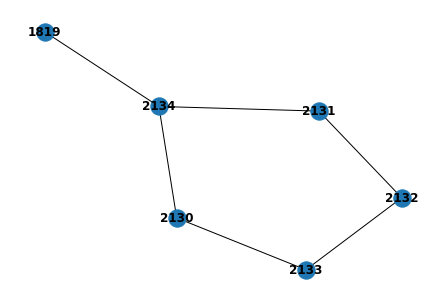

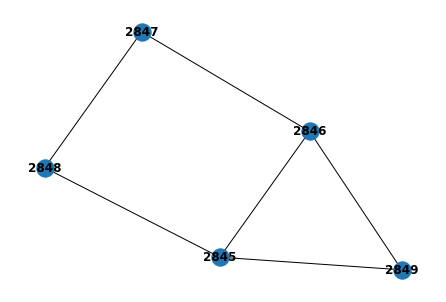

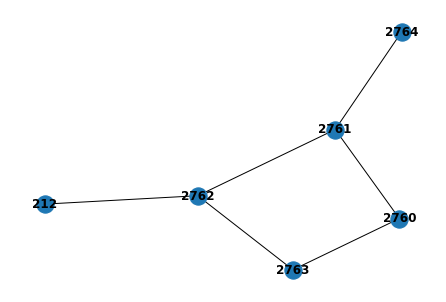

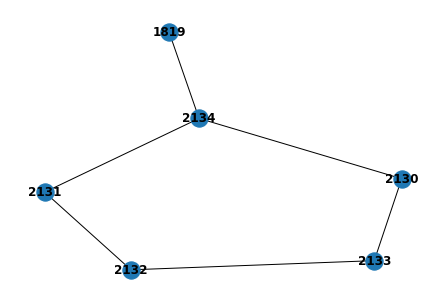

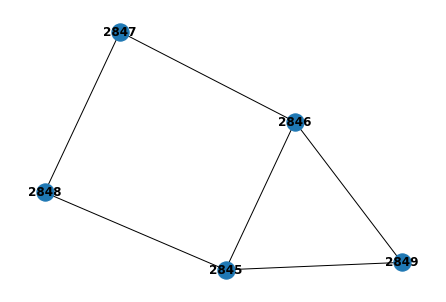

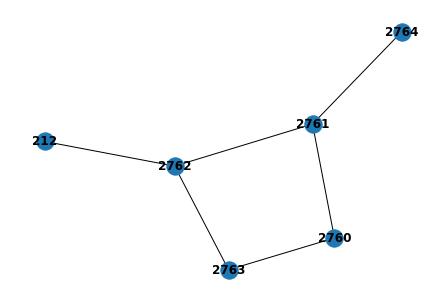

In [89]:
soft_related_preds = eval_related_pred(model, data, edge_masks_norm, test_nodes[:3], hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks_norm, test_nodes[:3], hard_mask=True, num_top_edges=6)

In [95]:
hard_related_preds

{'zero': array([[0.11795527, 0.36830395, 0.33995083, 0.17378987],
        [0.11795527, 0.36830395, 0.33995083, 0.17378987],
        [0.11795527, 0.36830395, 0.33995083, 0.17378987]], dtype=float32),
 'masked': array([[9.9374747e-01, 4.2805555e-03, 7.1502459e-04, 1.2568978e-03],
        [8.7083191e-01, 8.4124684e-02, 2.2014057e-02, 2.3029480e-02],
        [9.9570101e-01, 2.7732963e-03, 5.4168660e-04, 9.8383659e-04]],
       dtype=float32),
 'maskout': array([[0.11795527, 0.36830395, 0.33995083, 0.17378987],
        [0.11795527, 0.36830395, 0.33995083, 0.17378987],
        [0.11795527, 0.36830395, 0.33995083, 0.17378987]], dtype=float32),
 'origin': array([[0.13901399, 0.32813618, 0.3512559 , 0.18159385],
        [0.17053251, 0.3007605 , 0.3451422 , 0.18356483],
        [0.18382795, 0.2817398 , 0.34833506, 0.18609707]], dtype=float32),
 'true_label': array([2, 2, 2])}

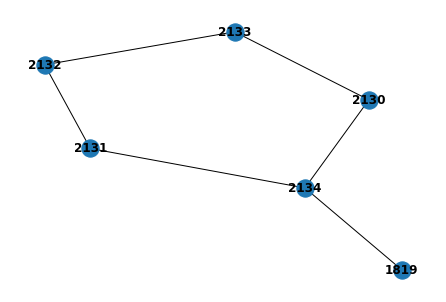

[19208 20488 20489 20490 20492 20493 20495]
tensor([0.5635, 0.1271, 1.1271, 0.6906, 0.5814, 0.5635, 1.5814])
[19208 20488 20489 20490 20491 20492 20493 20494 20495 20496 20497 20498
 20499 20500]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.]


<Figure size 432x288 with 0 Axes>

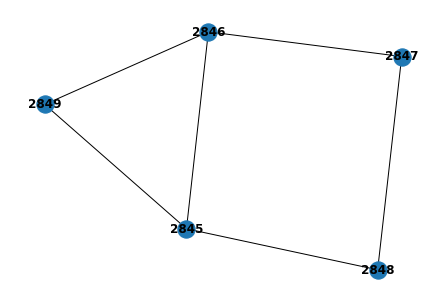

[ 4831  7794  9406  9651 10402 17992 22347 22348 22349 22351 22352 22355]
tensor([0.8935, 0.8935, 0.8935, 0.8935, 0.8935, 0.9712, 1.7882, 1.7903, 1.0841,
        1.0756, 1.2917, 1.0776])
[17992 22347 22348 22349 22350 22351 22352 22353 22354 22355 22356 22357
 22358 22359]
[1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

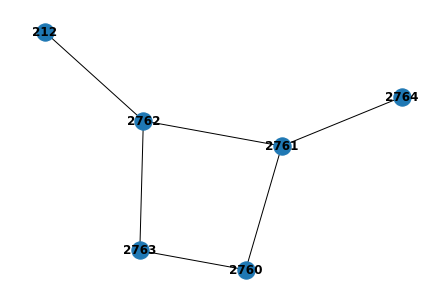

[ 6373 22126 22127 22128 22130 22131 22134]
tensor([0.8746, 0.9705, 1.0000, 0.2765, 1.8451, 1.2470, 1.8746])
[ 6373 22126 22127 22128 22129 22130 22131 22132 22133 22134 22135 22136
 22137 22138]
[1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

In [91]:
acc = eval_accuracy(data, edge_masks, test_nodes[:3], num_top_edges=6, is_hard_mask=False)
f1 = eval_fidelity(soft_related_preds)
f2 = eval_fidelity(hard_related_preds)

In [57]:
acc

{'recall': 0.9444444444444445,
 'precision': 0.9444444444444445,
 'f1_score': 0.9444444444444445,
 'ged': 1.0,
 'auc': 0.7360805699709738}

In [92]:
f1

{'fidelity_acc+': 0.6666666666666666,
 'fidelity_acc-': 1.0,
 'fidelity_prob+': 0.15664796217479623,
 'fidelity_prob-': 0.3263447354879077}

In [93]:
f2

{'fidelity_acc+': 1.0,
 'fidelity_acc-': 1.0,
 'fidelity_prob+': 0.008661214487669433,
 'fidelity_prob-': 0.3407104992959588}

In [23]:
def eval_fidelity(related_preds):
    fidelity_scores = {
        "fidelity_acc+": fidelity_acc(related_preds),
        "fidelity_acc-": fidelity_acc_inv(related_preds),
        "fidelity_prob+": fidelity_prob(related_preds),
        "fidelity_prob-": fidelity_prob_inv(related_preds),
    }
    return fidelity_scores

In [24]:
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

In [25]:
def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

In [34]:
def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

In [27]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

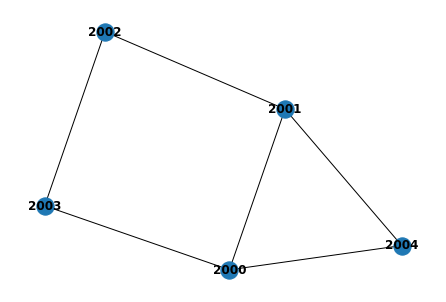

ValueError: too many values to unpack (expected 4)

<Figure size 432x288 with 0 Axes>

In [326]:
list_node_idx = range(n_basis,n_basis+500)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_sa_node(model, node_idx, data.x, data.edge_index, target = labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    #print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [29]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.22946859903381642 7.521739130434782 0.22946859903381642 0.22946859903381642


In [28]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [29]:
edge_masks = []

for node_idx in test_nodes:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)    

In [32]:
soft_related_preds = eval_related_pred(model, data, edge_masks, test_nodes, hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks, test_nodes, hard_mask=True, num_top_edges=6)


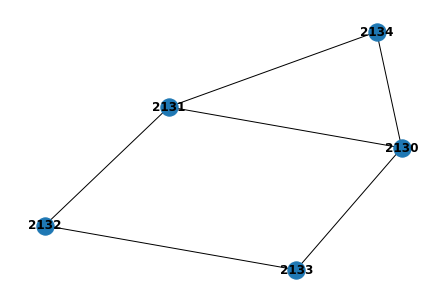

[19208 20488 20489 20490 20492 20493 20495]
tensor([0.0128, 0.0576, 0.0806, 0.0416, 0.0658, 0.0416, 0.0888])
[19208 20488 20489 20490 20491 20492 20493 20494 20495 20496 20497 20498
 20499 20500]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.]


<Figure size 432x288 with 0 Axes>

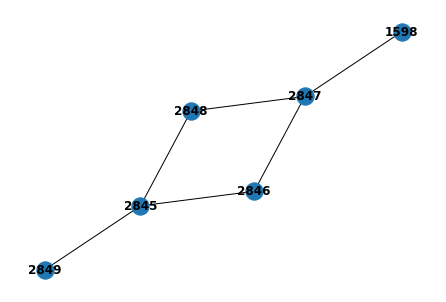

[ 4831  7794  9406  9651 10402 17992 22347 22348 22349 22351 22352 22355]
tensor([0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0386, 0.0502, 0.0721, 0.0389,
        0.0525, 0.0362, 0.0743])
[17992 22347 22348 22349 22350 22351 22352 22353 22354 22355 22356 22357
 22358 22359]
[1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

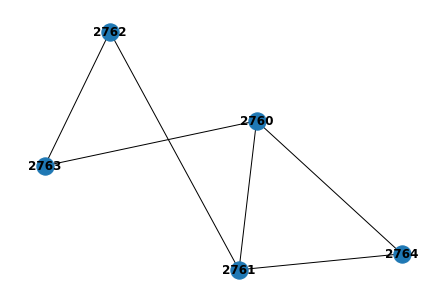

[ 2922  3367  4956  5081  5156  6357  6358  6359  6360  6361  6362  6363
  6364  6365  6366  6367  6368  6369  6370  6371  6372  6373 22126 22127
 22128 22130 22131 22134]
tensor([0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054,
        0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054,
        0.0054, 0.0054, 0.0054, 0.0357, 0.0538, 0.0776, 0.0426, 0.0550, 0.0383,
        0.0788])
[ 6373 22126 22127 22128 22129 22130 22131 22132 22133 22134 22135 22136
 22137 22138]
[1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

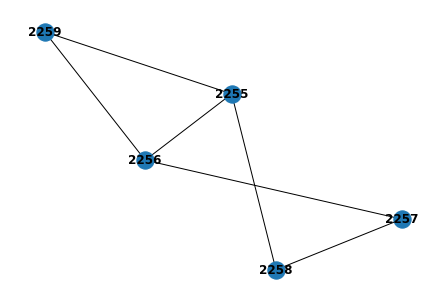

[ 3575 10741 12468 13724 15991 18145 20813 20814 20815 20817 20818 20820]
tensor([0.0523, 0.0523, 0.0523, 0.0523, 0.0523, 0.2682, 0.5264, 0.5045, 0.5264,
        0.4098, 0.4317, 0.3879])
[18145 20813 20814 20815 20816 20817 20818 20819 20820 20821 20822 20823
 20824 20825]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.]


<Figure size 432x288 with 0 Axes>

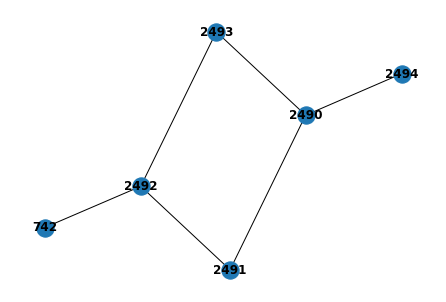

[ 5378  5847  7947  9259 10005 12178 21424 21425 21426 21428 21429 21432]
tensor([0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0386, 0.0502, 0.0721, 0.0389,
        0.0525, 0.0362, 0.0743])
[12178 21424 21425 21426 21427 21428 21429 21430 21431 21432 21433 21434
 21435 21436]
[1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

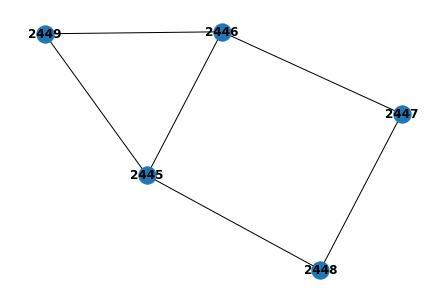

[15096 21307 21308 21309 21312 21313 21315]
tensor([0.0259, 0.0559, 0.0824, 0.0456, 0.0627, 0.0415, 0.0893])
[15096 21307 21308 21309 21310 21311 21312 21313 21314 21315 21316 21317
 21318 21319]
[1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

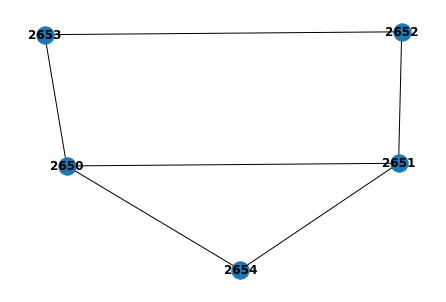

[ 1126  1466  8118 10060 10245 11637 11638 11639 11640 11641 21840 21841
 21842 21845 21846 21848]
tensor([0.0361, 0.0361, 0.0361, 0.0361, 0.0361, 0.0361, 0.0361, 0.0361, 0.0361,
        0.2358, 0.5177, 0.5140, 0.5759, 0.3783, 0.4575, 0.3746])
[11641 21840 21841 21842 21843 21844 21845 21846 21847 21848 21849 21850
 21851 21852]
[1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

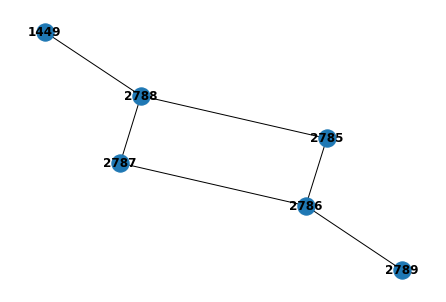

[    6    46   151   187   240   317   404   489   630   631   632   633
   634   635   636   637   638   639   640   641   642   643   644   645
   646   647   648   649   650   651   652   653   654   655   656   657
   658   659   660   661   662   663   664   665   666   667   668   669
   670   671   672   673   674   675   676   677   678   679   680   681
   682   683   684   685   686   687   688   689   690   691   692   693
   694   695   696   697   698   699   700   701   702   703   704   705
   706   707   708   709   710   711   712   713   714   715   716   717
   718   719   720   721   722   723   724   725   726   727   728   729
   730   731   732   733   734   735   736   737   738   739   740   741
   742   743   744   745   746   747   748   749   750   751   752   753
   754   867   983  1072  1094  1335  1419  1420  1421  1422  1423  1424
  1425  1426  1427  1428  1429  1430  1431  1432  1433  1434  1435  1436
  1437  1438  1439  1440  1441  1442  1443  1444  1

<Figure size 432x288 with 0 Axes>

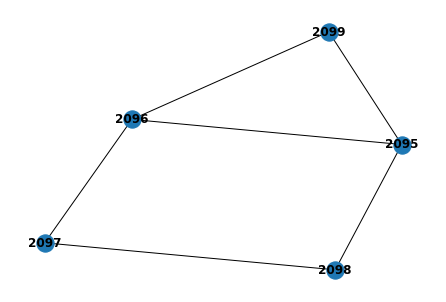

[16601 20397 20398 20399 20401 20402 20405]
tensor([0.1621, 0.5602, 0.5124, 0.5966, 0.3976, 0.5075, 0.3498])
[16601 20397 20398 20399 20400 20401 20402 20403 20404 20405 20406 20407
 20408 20409]
[1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2.]


<Figure size 432x288 with 0 Axes>

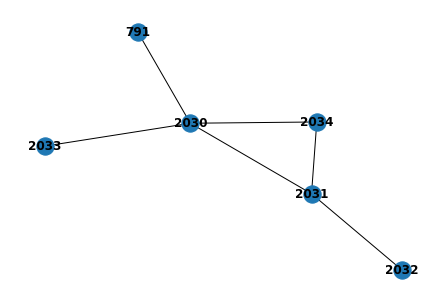

[  421   428   573  1088  1104  1252  1306  1426  2032  2364  2535  2687
  2695  2835  2863  2986  3065  3095  3451  3605  3630  3652  3808  3852
  3957  3958  3959  3960  3961  3962  3963  3964  3965  3966  3967  3968
  3969  3970  3971  3972  3973  3974  3975  3976  3977  3978  3979  3980
  3981  3982  3983  3984  3985  4277  4330  5393  5394  5395  5396  5397
  5398  5399  5400  5401  5402  5403  5404  5405  5406  5407  5408  5409
  5410  5516  5517  5518  5519  5520  5521  5522  5523  5524  5525  5526
  5527  5555  6498  6499  6500  6501  6502  6503  6504  6505  6506  6507
  6508  6509  6510  6511  6512  6513  6514  6728  6729  6730  6731  6732
  6733  6734  6735  6736  6737  6738  7744  9112 12579 12580 13153 13154
 20229 20230 20231 20233 20234 20236]
tensor([0.0092, 0.0128, 0.0192, 0.0092, 0.0132, 0.0111, 0.0111, 0.0092, 0.0128,
        0.0128, 0.0192, 0.0092, 0.0113, 0.0132, 0.0113, 0.0132, 0.0111, 0.0128,
        0.0132, 0.0092, 0.0111, 0.0113, 0.0113, 0.0111, 0.0092, 0.0092, 

<Figure size 432x288 with 0 Axes>

In [35]:
acc = eval_accuracy(data, edge_masks, test_nodes, num_top_edges=6, is_hard_mask=False)
f1 = eval_fidelity(soft_related_preds)
f2 = eval_fidelity(hard_related_preds)

In [42]:
f1 = eval_fidelity(soft_related_preds)
f1 = {k+'_soft':v for k,v in f1.items()}
f1

{'fidelity_acc+_soft': 0.3,
 'fidelity_acc-_soft': 0.6,
 'fidelity_prob+_soft': 0.07853306356040679,
 'fidelity_prob-_soft': 0.014066697589421605}

In [43]:
f2 = eval_fidelity(hard_related_preds)
f2

{'fidelity_acc+': 1.0,
 'fidelity_acc-': 0.7,
 'fidelity_prob+': 0.23400141824288426,
 'fidelity_prob-': 0.2726927560670872}

In [32]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


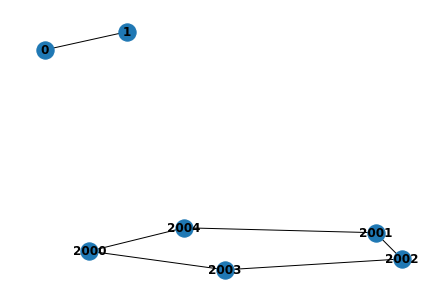

tensor([[2000, 2001, 2001, 2002, 2000,    0],
        [2004, 2004, 2002, 2003, 2003,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

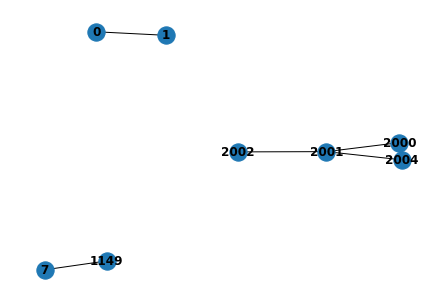

tensor([[2000, 2001, 2001, 2000,    0, 1149],
        [2004, 2004, 2002, 2001,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

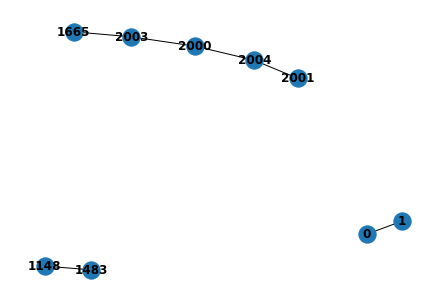

tensor([[2000, 2001, 1665, 2000,    0, 1148],
        [2004, 2004, 2003, 2003,    1, 1483]])
f1_score, ged 0.5 8.0
[1.67100430e-02 9.87148285e-03 2.71797180e-05 1.99079514e-04
 1.48463249e-03 1.48463249e-03 1.48463249e-03 6.90361261e-02
 5.58915138e-02 1.61062956e-01 9.20534134e-03 2.72258520e-02
 1.61062956e-01 5.58915138e-02 2.18153000e-04 9.20534134e-03
 2.72258520e-02 5.58915138e-02]


<Figure size 432x288 with 0 Axes>

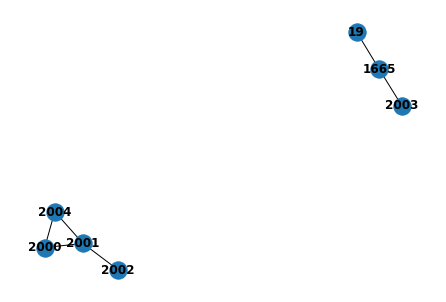

tensor([[2000, 2001, 1665, 2000, 2001,   19],
        [2004, 2004, 2003, 2001, 2002, 1665]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

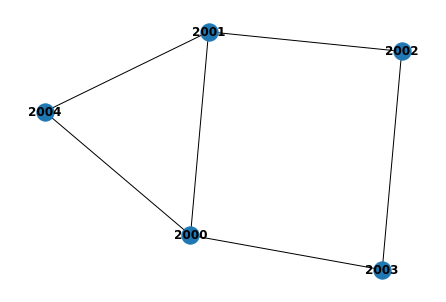

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2004, 2002, 2004, 2001, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


<Figure size 432x288 with 0 Axes>

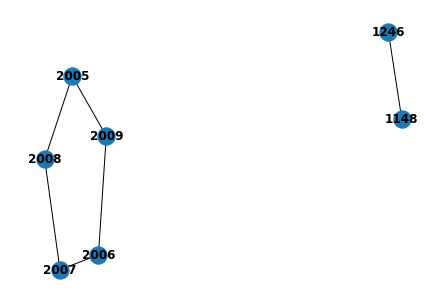

tensor([[2006, 2005, 2006, 2007, 2005, 1148],
        [2009, 2009, 2007, 2008, 2008, 1246]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

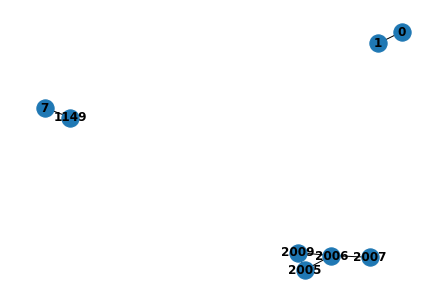

tensor([[2006, 2005, 2006, 2005,    0, 1149],
        [2009, 2009, 2007, 2006,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

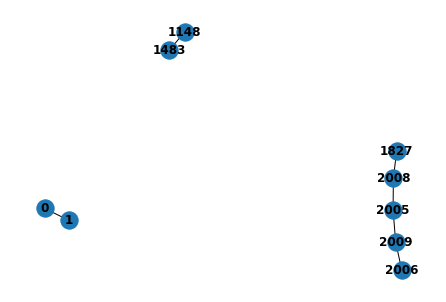

tensor([[2006, 2005, 1827, 2005,    0, 1148],
        [2009, 2009, 2008, 2008,    1, 1483]])
f1_score, ged 0.5 8.0
[0.01272047 0.00222707 0.00063252 0.00063252 0.00029409 0.00203836
 0.00135851 0.00164139 0.00164139 0.05118978 0.05576301 0.154006
 0.01026452 0.03008842 0.154006   0.05576301 0.01026452 0.03008842
 0.05576301]


<Figure size 432x288 with 0 Axes>

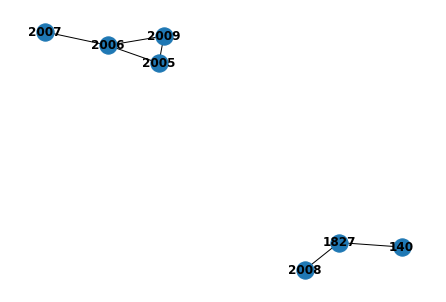

tensor([[2006, 2005, 2005, 1827, 2006,  140],
        [2009, 2009, 2006, 2008, 2007, 1827]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

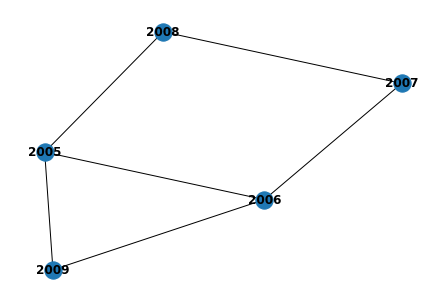

tensor([[2005, 2006, 2006, 2005, 2007, 2005],
        [2009, 2007, 2009, 2006, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

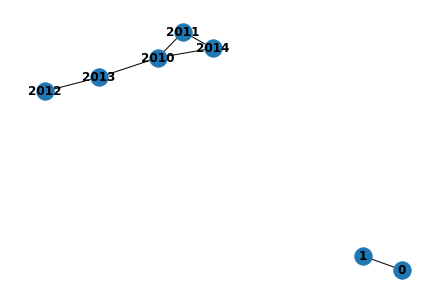

tensor([[2010, 2011, 2010, 2012, 2010,    0],
        [2014, 2014, 2013, 2013, 2011,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

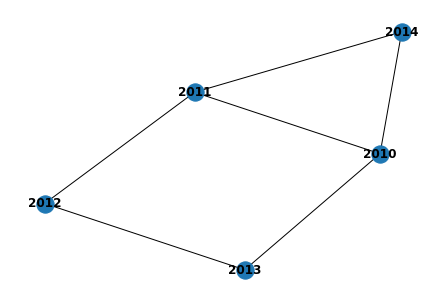

tensor([[2010, 2011, 2010, 2012, 2010, 2011],
        [2014, 2014, 2013, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[1.03420019e-02 9.20665264e-03 2.82919407e-03 7.63416290e-04
 9.97781754e-05 1.35302544e-04 5.19633293e-04 7.36594200e-04
 1.16193295e-03 7.75719881e-02 8.66246223e-03 2.57548094e-02
 1.64820671e-01 5.59939146e-02 1.64820671e-01 8.66246223e-03
 2.57548094e-02 5.59939146e-02 5.59473038e-03 5.59939146e-02]


<Figure size 432x288 with 0 Axes>

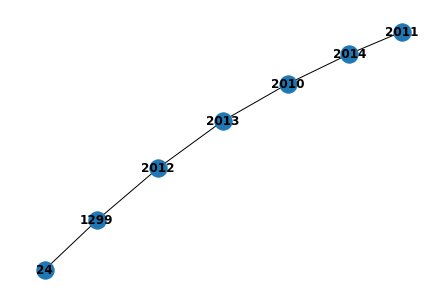

tensor([[2011, 2010, 1299, 2012, 2010,   24],
        [2014, 2014, 2012, 2013, 2013, 1299]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

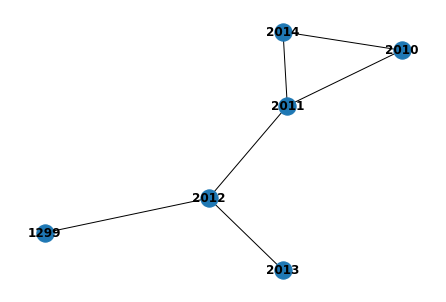

tensor([[2012, 2010, 2011, 2010, 1299, 2011],
        [2013, 2014, 2014, 2011, 2012, 2012]])
f1_score, ged 0.8333333333333334 3.0
[0.14103723 0.2866776  0.103526   0.03252065 0.02846277 0.49933362
 0.14103723 0.2866776  0.02269602 0.02846277 0.02269602 0.14032996]


<Figure size 432x288 with 0 Axes>

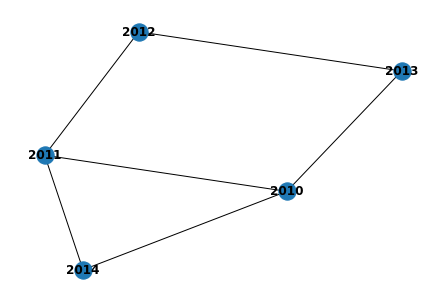

tensor([[2011, 2010, 2012, 2010, 2010, 2011],
        [2014, 2013, 2013, 2011, 2014, 2012]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

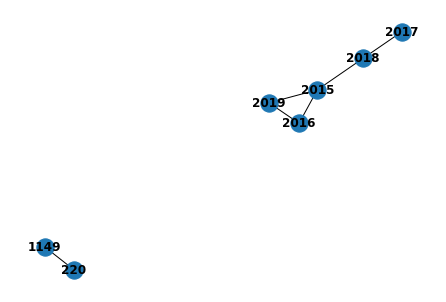

tensor([[2016, 2015, 2015, 2017, 2015, 1149],
        [2019, 2019, 2018, 2018, 2016,  220]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

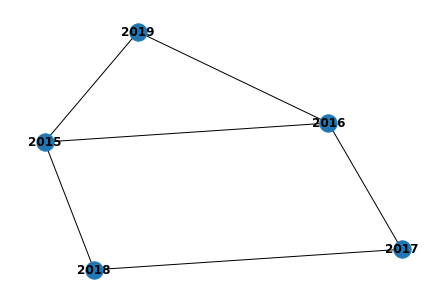

tensor([[2015, 2016, 2015, 2017, 2015, 2016],
        [2019, 2019, 2018, 2018, 2016, 2017]])
f1_score, ged 1.0 0.0
[1.22464895e-02 4.41122055e-03 7.96675682e-04 5.62334061e-03
 5.66244125e-05 3.92079353e-04 1.16348267e-03 7.37428665e-04
 3.09109688e-04 7.73830414e-02 8.67474079e-03 2.57881880e-02
 1.64734364e-01 5.59912920e-02 1.64734364e-01 8.67474079e-03
 2.57881880e-02 5.59912920e-02 5.47087193e-03 5.59912920e-02]


<Figure size 432x288 with 0 Axes>

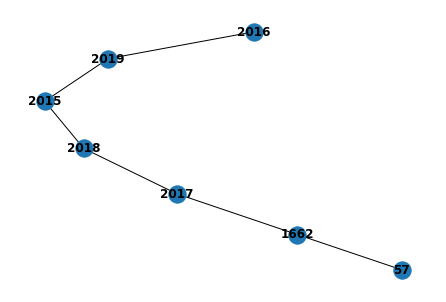

tensor([[2015, 2016, 1662, 2015, 2017,   57],
        [2019, 2019, 2017, 2018, 2018, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [33]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [144]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8166666666666668 3.55 0.8166666666666668 0.8166666666666668


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [47]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [392]:
import time 


list_node_idx = range(n_basis,n_basis+3)#*n_shapes)

duration_samples = []
edge_masks = []



for node_idx in test_nodes[:3]:
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    


[0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.81466096
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 1.4879074
 0.52667295 0.73702345 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.58870331 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295
 0.52667295 0.52667295 0.52667295 0.52667295 0.52667295 0.52667

[0.44142222 0.44142222 0.44142222 0.44142222 0.44142222 0.44142222
 0.44142222 0.44142222 0.44142222 0.44142222 0.44142222 0.44142222
 1.44142222 0.44142222 0.44142222 2.         1.99892333 2.
 1.44142222 2.         2.         2.         2.         1.99892333
 1.99892333 1.99892333 2.         2.        ]
tensor([[2910, 2911, 2910, 2911, 2910, 2912],
        [2911, 2912, 2914, 2914, 2913, 2913]])
[0.99997348 2.         1.99998969 2.         2.         1.99997348
 2.         0.99997348 1.99997348 1.99996318 1.99998969 1.99996318
 2.         2.        ]
tensor([[2275, 2275, 2276, 2275, 2276, 2277],
        [2276, 2279, 2279, 2278, 2277, 2278]])


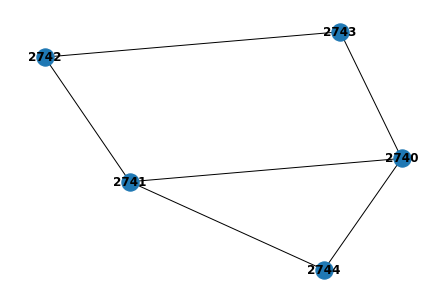

ValueError: continuous format is not supported

<Figure size 432x288 with 0 Axes>

In [525]:
soft_related_preds = eval_related_pred(model, data, edge_masks, test_nodes[:3], hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks, test_nodes[:3], hard_mask=True, num_top_edges=6)

acc = eval_accuracy(data, edge_masks, test_nodes, num_top_edges=6, is_hard_mask=False)
f1 = eval_fidelity(soft_related_preds)
f2 = eval_fidelity(hard_related_preds)

In [80]:
print(acc, f1, f2)

0.7497902097902097 1.65 0.7249999999999999 0.785357142857143 nan


/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
def explain_random(model, node_idx, x, edge_index, target, include_edges=None):
    return np.random.uniform(size=edge_index.shape[1])

[0.29218136 0.15195296 0.23682181 ... 0.65071381 0.36042914 0.02769381]


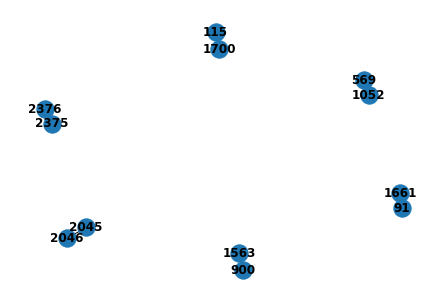

tensor([[2375,   91,  900,  569, 2045,  115],
        [2376, 1661, 1563, 1052, 2046, 1700]])
f1_score, ged 0 15.0
[0.25748322 0.55452075 0.77116991 ... 0.08410639 0.46548574 0.58332501]


<Figure size 432x288 with 0 Axes>

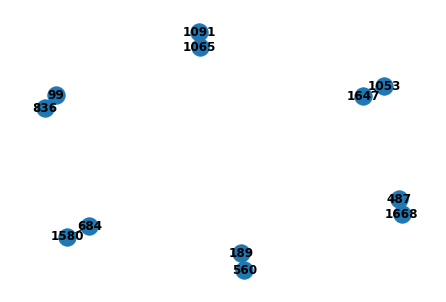

tensor([[  99,  684, 1065, 1053,  189,  487],
        [ 836, 1580, 1091, 1647,  560, 1668]])
f1_score, ged 0 15.0
[0.29058395 0.18983893 0.99145235 ... 0.82166589 0.00548186 0.03905489]


<Figure size 432x288 with 0 Axes>

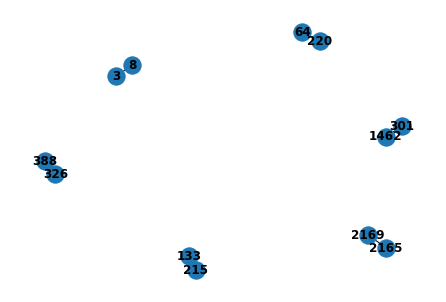

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [45]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_random(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [46]:
def explain_distance(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    length = nx.shortest_path_length(g, target=node_idx)

    def get_attr(node):
        if node in length:
            return 1 / (length[node] + 1)
        return 0

    edge_sources = edge_index[1].cpu().numpy()
    return np.array([get_attr(node) for node in edge_sources])

[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


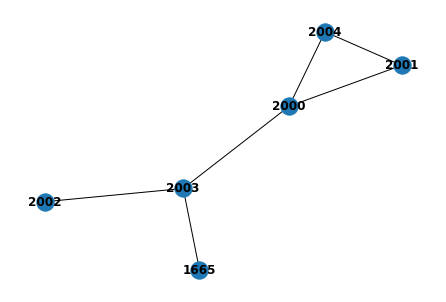

tensor([[1665, 2002, 2000, 2001, 2000, 2000],
        [2003, 2003, 2004, 2004, 2003, 2001]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

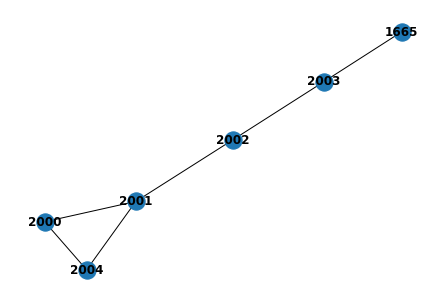

tensor([[2000, 2000, 2001, 2001, 1665, 2002],
        [2001, 2004, 2004, 2002, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

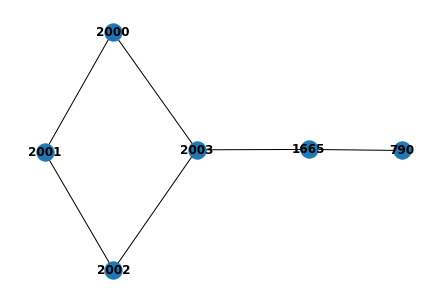

tensor([[2001, 1665, 2002, 2000, 2000,  790],
        [2002, 2003, 2003, 2003, 2001, 1665]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.25       0.25       ... 0.125      0.16666667 0.14285714]


<Figure size 432x288 with 0 Axes>

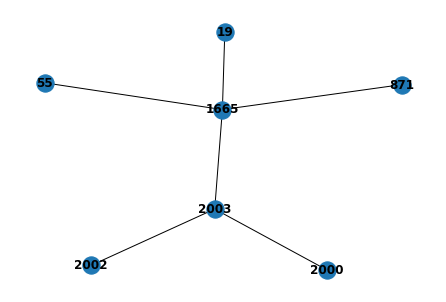

tensor([[1665, 2002, 2000,   55,   19,  871],
        [2003, 2003, 2003, 1665, 1665, 1665]])
f1_score, ged 0.3333333333333333 6.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

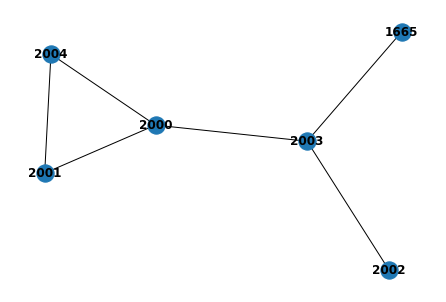

tensor([[2000, 2001, 2000, 1665, 2002, 2000],
        [2004, 2004, 2001, 2003, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

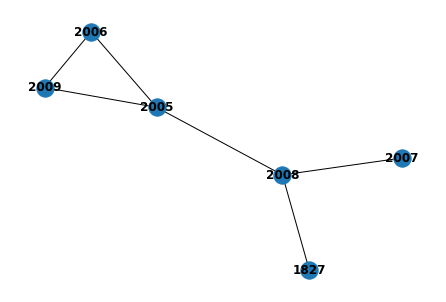

tensor([[2005, 1827, 2007, 2006, 2005, 2005],
        [2006, 2008, 2008, 2009, 2009, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

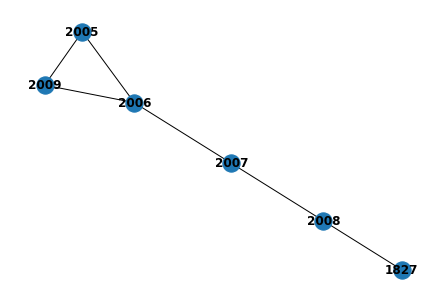

tensor([[2005, 2006, 2006, 2005, 1827, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

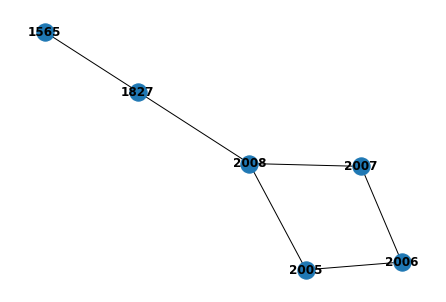

tensor([[2006, 2005, 1827, 2007, 2005, 1565],
        [2007, 2006, 2008, 2008, 2008, 1827]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

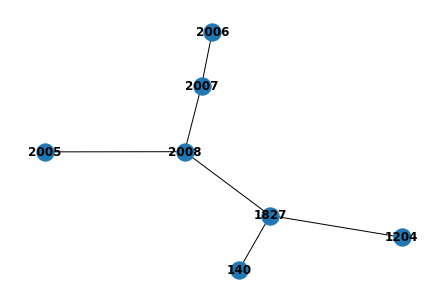

tensor([[2005, 1827, 2007,  140, 1204, 2006],
        [2008, 2008, 2008, 1827, 1827, 2007]])
f1_score, ged 0.5 6.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

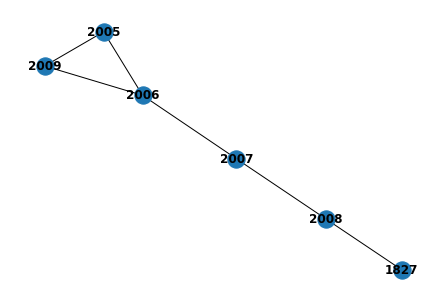

tensor([[2006, 2005, 2005, 1827, 2007, 2006],
        [2009, 2009, 2006, 2008, 2008, 2007]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

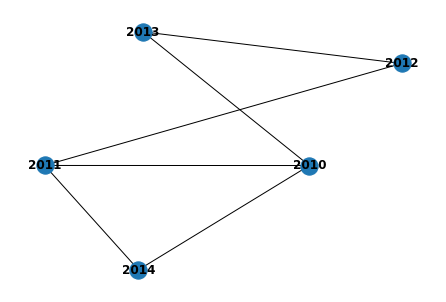

tensor([[2010, 2010, 2011, 2012, 2010, 2011],
        [2013, 2014, 2014, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

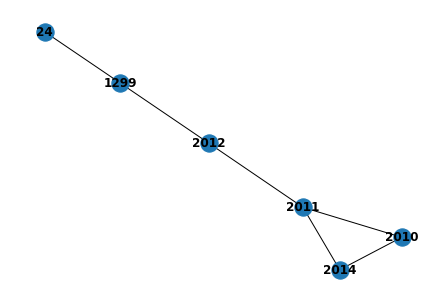

tensor([[2010, 2010, 2011, 2011, 1299,   24],
        [2011, 2014, 2012, 2014, 2012, 1299]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

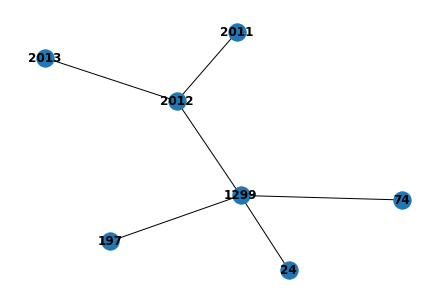

tensor([[2011, 1299,   24, 2012,  197,   74],
        [2012, 2012, 1299, 2013, 1299, 1299]])
f1_score, ged 0.3333333333333333 6.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

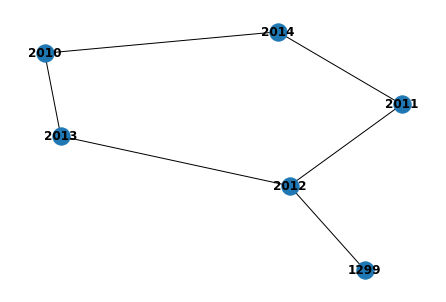

tensor([[2010, 2012, 2011, 1299, 2010, 2011],
        [2013, 2013, 2012, 2012, 2014, 2014]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

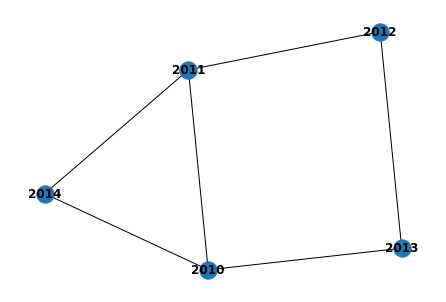

tensor([[2010, 2011, 2010, 2010, 2011, 2012],
        [2014, 2014, 2011, 2013, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

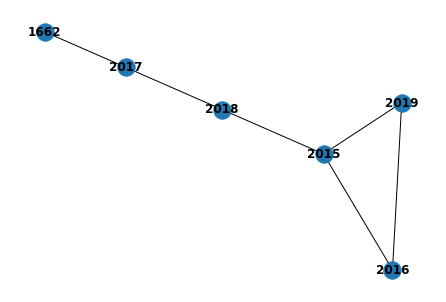

tensor([[2015, 2015, 2016, 2015, 2017, 1662],
        [2019, 2016, 2019, 2018, 2018, 2017]])
f1_score, ged 0.8333333333333334 3.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

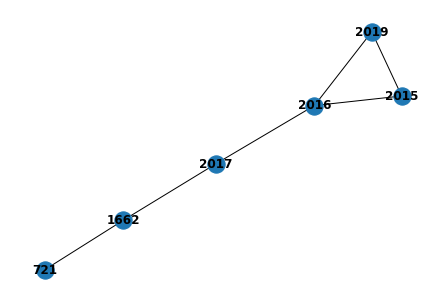

tensor([[2015, 2015, 1662, 2016, 2016,  721],
        [2016, 2019, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 3.0
[0.25       0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

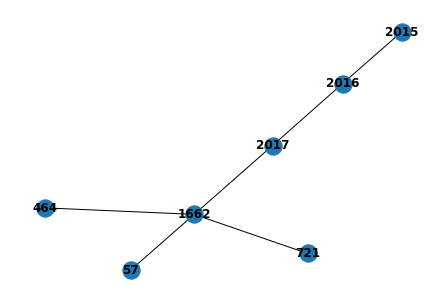

tensor([[2016, 1662,   57, 2015,  464,  721],
        [2017, 2017, 1662, 2016, 1662, 1662]])
f1_score, ged 0.3333333333333333 6.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

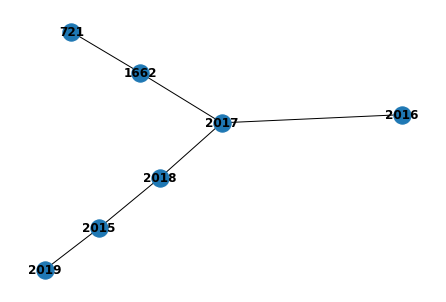

tensor([[2015, 2017, 1662, 2016, 2015,  721],
        [2018, 2018, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

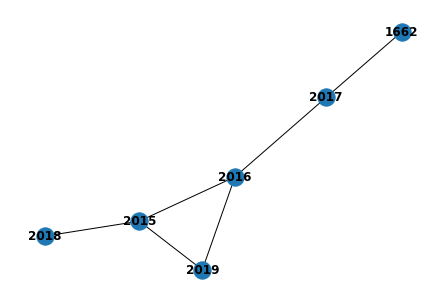

tensor([[2015, 2016, 2015, 1662, 2016, 2015],
        [2019, 2019, 2016, 2017, 2017, 2018]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

In [47]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_distance(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [48]:
def explain_pagerank(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    pagerank = nx.pagerank(g, personalization={node_idx: 1})

    node_attr = np.zeros(x.shape[0])
    for node, value in pagerank.items():
        node_attr[node] = value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[1.32453888e-03 1.69397530e-03 2.54784989e-03 ... 7.50785614e-06
 1.33518254e-05 9.68526597e-06]


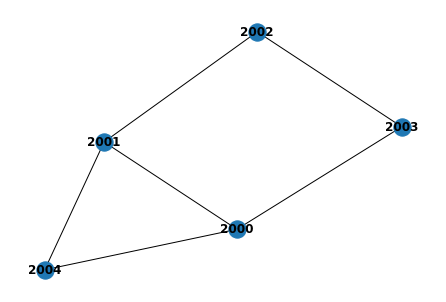

tensor([[2000, 2000, 2000, 2001, 2001, 2002],
        [2001, 2004, 2003, 2004, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.11600353e-03 1.42445958e-03 2.13800134e-03 ... 6.95529024e-06
 1.20614140e-05 8.92237558e-06]


<Figure size 432x288 with 0 Axes>

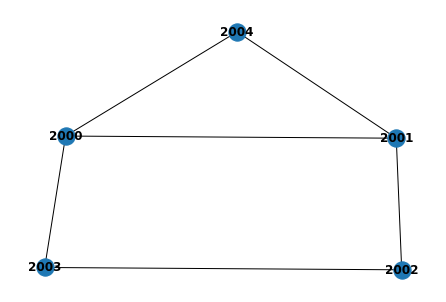

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2001, 2004, 2002, 2004, 2003, 2003]])
f1_score, ged 1.0 0.0
[1.53740046e-03 1.96925299e-03 2.96676362e-03 ... 8.06205697e-06
 1.46552188e-05 1.04518902e-05]


<Figure size 432x288 with 0 Axes>

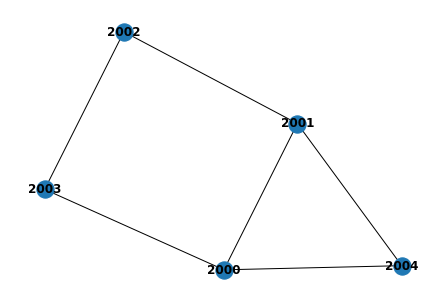

tensor([[2001, 2002, 2000, 2000, 2001, 2000],
        [2002, 2003, 2001, 2003, 2004, 2004]])
f1_score, ged 1.0 0.0
[2.48959870e-03 3.19737775e-03 4.83052295e-03 ... 1.13912594e-05
 2.15790659e-05 1.49084293e-05]


<Figure size 432x288 with 0 Axes>

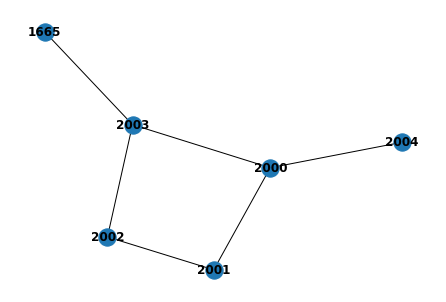

tensor([[2000, 2002, 1665, 2000, 2001, 2000],
        [2003, 2003, 2003, 2001, 2002, 2004]])
f1_score, ged 0.8333333333333334 3.0
[1.04618233e-03 1.33413151e-03 2.00045765e-03 ... 6.77583828e-06
 1.16372338e-05 8.67374532e-06]


<Figure size 432x288 with 0 Axes>

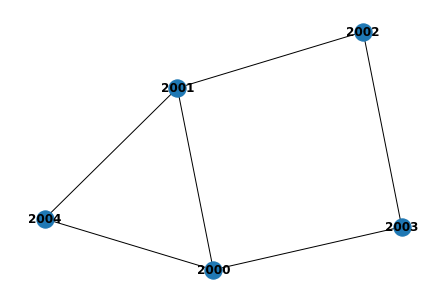

tensor([[2001, 2000, 2000, 2000, 2001, 2002],
        [2004, 2004, 2001, 2003, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.10583891e-03 1.24979465e-03 1.44841009e-03 ... 7.34985856e-06
 1.29791515e-05 9.46644075e-06]


<Figure size 432x288 with 0 Axes>

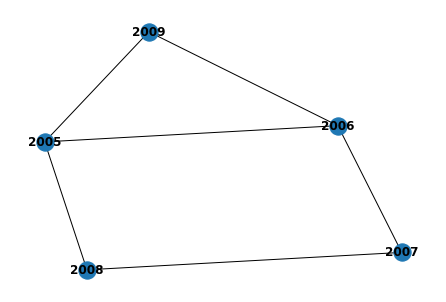

tensor([[2005, 2005, 2005, 2006, 2006, 2007],
        [2006, 2009, 2008, 2009, 2007, 2008]])
f1_score, ged 1.0 0.0
[9.25316400e-04 1.04567418e-03 1.21195350e-03 ... 6.11609110e-06
 1.08199168e-05 7.88050674e-06]


<Figure size 432x288 with 0 Axes>

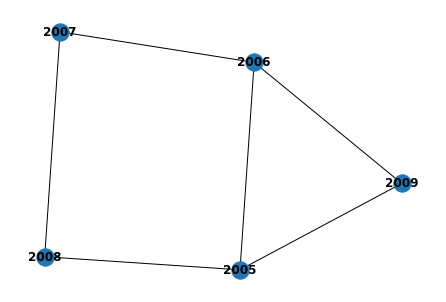

tensor([[2005, 2006, 2006, 2005, 2005, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 1.0 0.0
[1.28078357e-03 1.44828793e-03 1.67755761e-03 ... 7.87297539e-06
 1.42123585e-05 1.01904148e-05]


<Figure size 432x288 with 0 Axes>

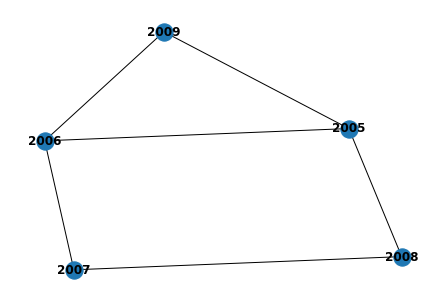

tensor([[2006, 2007, 2005, 2005, 2006, 2005],
        [2007, 2008, 2006, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0
[2.06633050e-03 2.33872893e-03 2.70648849e-03 ... 1.10691951e-05
 2.08329554e-05 1.44643198e-05]


<Figure size 432x288 with 0 Axes>

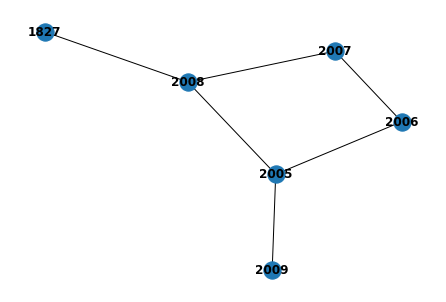

tensor([[2005, 2007, 1827, 2005, 2006, 2005],
        [2008, 2008, 2008, 2006, 2007, 2009]])
f1_score, ged 0.8333333333333334 3.0
[8.67691112e-04 9.80298783e-04 1.13647359e-03 ... 5.94188816e-06
 1.04109897e-05 7.63981236e-06]


<Figure size 432x288 with 0 Axes>

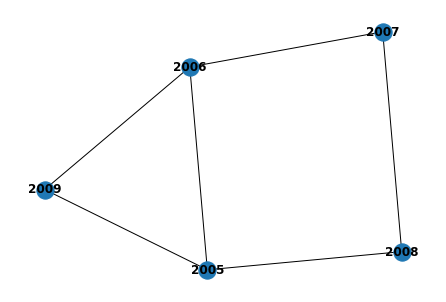

tensor([[2006, 2005, 2005, 2005, 2006, 2007],
        [2009, 2009, 2006, 2008, 2007, 2008]])
f1_score, ged 1.0 0.0
[1.65377137e-03 1.71813456e-03 1.90441342e-03 ... 6.74515672e-06
 1.15672815e-05 8.63167774e-06]


<Figure size 432x288 with 0 Axes>

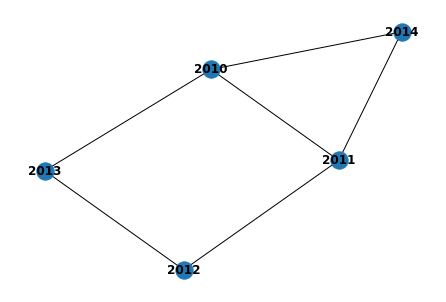

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2011, 2014, 2013, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[1.97141972e-03 2.04737839e-03 2.26753949e-03 ... 7.24934231e-06
 1.27500628e-05 9.32854671e-06]


<Figure size 432x288 with 0 Axes>

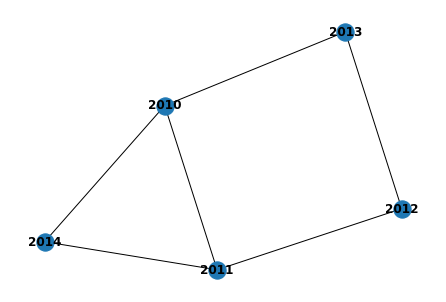

tensor([[2010, 2011, 2011, 2010, 2010, 2012],
        [2011, 2014, 2012, 2014, 2013, 2013]])
f1_score, ged 1.0 0.0
[3.73993962e-03 3.88100145e-03 4.29112664e-03 ... 1.08703802e-05
 2.03883470e-05 1.41929867e-05]


<Figure size 432x288 with 0 Axes>

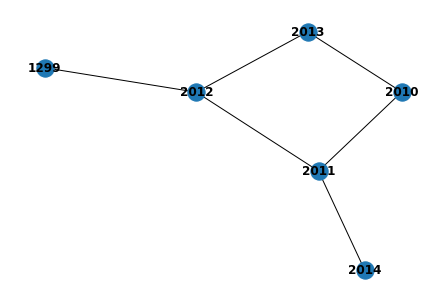

tensor([[2011, 2012, 1299, 2010, 2010, 2011],
        [2012, 2013, 2012, 2011, 2013, 2014]])
f1_score, ged 0.8333333333333334 3.0
[2.29608740e-03 2.38386118e-03 2.63856353e-03 ... 7.75403032e-06
 1.39431600e-05 1.00275987e-05]


<Figure size 432x288 with 0 Axes>

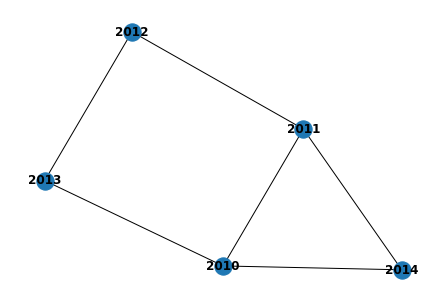

tensor([[2010, 2012, 2010, 2011, 2010, 2011],
        [2013, 2013, 2011, 2012, 2014, 2014]])
f1_score, ged 1.0 0.0
[1.54718860e-03 1.60768123e-03 1.78263570e-03 ... 6.58197222e-06
 1.11793901e-05 8.40524271e-06]


<Figure size 432x288 with 0 Axes>

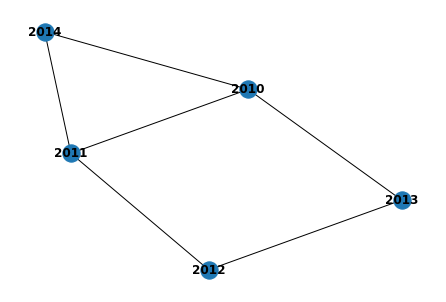

tensor([[2010, 2011, 2010, 2011, 2010, 2012],
        [2014, 2014, 2011, 2012, 2013, 2013]])
f1_score, ged 1.0 0.0
[1.06842299e-03 1.07464209e-03 1.30528532e-03 ... 7.04286122e-06
 1.22708800e-05 9.04436303e-06]


<Figure size 432x288 with 0 Axes>

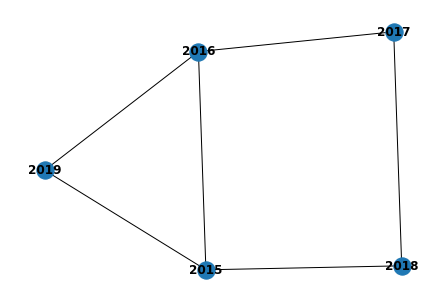

tensor([[2015, 2015, 2015, 2016, 2016, 2017],
        [2016, 2019, 2018, 2019, 2017, 2018]])
f1_score, ged 1.0 0.0
[1.26726652e-03 1.27334980e-03 1.54683762e-03 ... 7.61664186e-06
 1.36094772e-05 9.83570713e-06]


<Figure size 432x288 with 0 Axes>

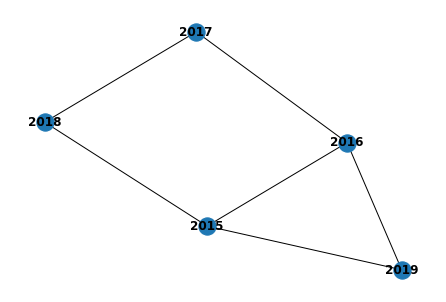

tensor([[2015, 2016, 2016, 2015, 2015, 2017],
        [2016, 2019, 2017, 2019, 2018, 2018]])
f1_score, ged 1.0 0.0
[2.37870386e-03 2.38496700e-03 2.89791356e-03 ... 1.16142031e-05
 2.20951259e-05 1.52149286e-05]


<Figure size 432x288 with 0 Axes>

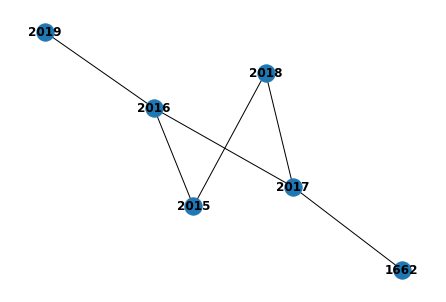

tensor([[2016, 2017, 1662, 2015, 2015, 2016],
        [2017, 2018, 2017, 2016, 2018, 2019]])
f1_score, ged 0.8333333333333334 3.0
[1.47018725e-03 1.47606849e-03 1.79326152e-03 ... 8.19252175e-06
 1.49616176e-05 1.06318333e-05]


<Figure size 432x288 with 0 Axes>

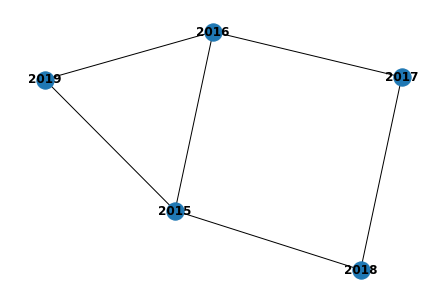

tensor([[2015, 2017, 2015, 2016, 2015, 2016],
        [2018, 2018, 2016, 2017, 2019, 2019]])
f1_score, ged 1.0 0.0
[1.00187901e-03 1.00817722e-03 1.22450018e-03 ... 6.85628102e-06
 1.18311067e-05 8.78573719e-06]


<Figure size 432x288 with 0 Axes>

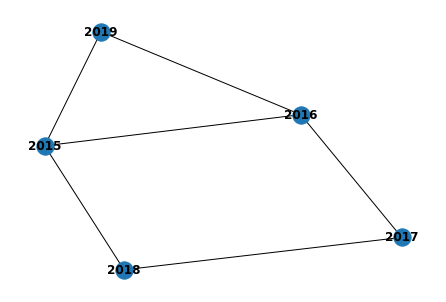

tensor([[2015, 2016, 2015, 2016, 2015, 2017],
        [2019, 2019, 2016, 2017, 2018, 2018]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

In [49]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pagerank(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [50]:
def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing):
            layers.append(module)
    return layers

In [51]:
def explain_gradXact(model, node_idx, x, edge_index, target, include_edges=None):
    # Captum default implementation of LayerGradCam does not average over nodes for different channels because of
    # different assumptions on tensor shapes
    input_mask = x.clone().requires_grad_(True).to(device)
    layers = get_all_convolution_layers(model)
    node_attrs = []
    for layer in layers:
        layer_gc = LayerGradCam(model_forward_node, layer)
        node_attr = layer_gc.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx))
        node_attr = node_attr.cpu().detach().numpy().ravel()
        node_attrs.append(node_attr)
    node_attr = np.array(node_attrs).mean(axis=0)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [1]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_gradXact(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

NameError: name 'n_basis' is not defined